# Classification. Part 2
---
Author: Anatoliy Durkin

Updated: 17.03.2025

---
В данном ноутбуке будут рассмотрены несколько моделей классификации, новые функции для метрик и сами новые метрики, а также будет уделено внимание подбору гиперпараметров для моделей.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

В прошлом ноутбуке мы писали функцию, выводившую все необходимые нам метрики вместе. Мы импортировали несколько функций, но в этом ноутбуке используем только две: `confusion_matrix` выводит матрицу ошибок, а `classification_report` выдает остальные метрики, увидим уже на примере. Зачем нужен `fill_diagonal`, увидим в конце ноутбука.

In [17]:
def metrics(target, pred, fill=False):
    print(classification_report(target, pred))
    matrix = np.array(confusion_matrix(target, pred))
    if fill:
        np.fill_diagonal(matrix, 0)
    sns.heatmap(matrix, annot=True, fmt='.0f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Матрица ошибок')

## Naive Bayes
---

Знаете ли вы метод "съешь лягушку"? Это о том, что нужно выполнить самую неприятную задачу сразу, не откладывая. Так что съедим лягушку и слегка окунёмся в NLP, или Natural language processing - обработка естественного языка.

В этой сфере может быть множество задач классификации, например, отделение спама. Но мы рассмотрим задачу определения кликбейта среди новостных заголовков.

> Кликбейт (англ. clickbait от click «щелчок» + bait «приманка») — уничижительный термин, описывающий веб-контент, целью которого является получение дохода от онлайн-рекламы, особенно в ущерб качеству или точности информации.

А как модель используем наивный байессовский классиикатор.

Итак, познакомимся с данными.

In [20]:
titles = pd.read_csv('titles_data.csv', sep=';')

In [21]:
titles

,titles,target
0,Родственник раскрыл настоящую фамилию Пугачёво...,1
1,Предсказания Матроны Московской на 2024-й год:...,1
2,"Пророчество схимонахини Нины об антихристе, ми...",1
3,«Думал об этом»: что Путин сказал о своем прее...,1
4,Путин поручил уведомить россиян об изменениях ...,1
...,...,...
3193,Путин поручил передать Республике Крым все акц...,0
3194,ЕК изучит просьбу Венгрии по нарушению Болгари...,0
3195,"Глава ""Россетей"" доложил Путину о достижении ц...",0
3196,"Платформа ""Мой экспорт"" научит устанавливать д...",0


Поделим выборку на обучающую и тестовую.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(titles['titles'], titles['target'], test_size=0.2, random_state=42)

Конечно, модели не могут просто так работать с обычным текстом. Необходимы какие-то преобразования. Все модели спокойно работают с числами, значит нужно превратить текст в числа. И тут есть два важных процесса: токенизация и векторизация.

> Токенизация — процесс разбиения текстового документа на отдельные слова, которые называются токенами.

> Векторизация – это термин, обозначающий классический подход к преобразованию входных данных из их исходного формата (например, текста) в векторы действительных чисел, которые понятны моделям машинного обучения.

---
Как мы применим это к нашим данным?

Например, для определения кликбейта можно посчитать, как часто слова встречаются в заголовках. Скорее всего определенные слова могут сигнализировать нам о кликбейте.

В этом нам может помочь `CountVectorizer`, который считает, сколько раз каждое слово встречается в определенной строке.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
txt = ['мама мыла раму',
      'мама чинила раму',
      'мама мыла, мама чинила']

In [25]:
vectorizer = CountVectorizer()
txt = vectorizer.fit_transform(txt)

In [26]:
# результат
txt.toarray()

array([[1, 1, 1, 0],
       [1, 0, 1, 1],
       [2, 1, 0, 1]])

In [27]:
# словарь
vectorizer.get_feature_names_out()

array(['мама', 'мыла', 'раму', 'чинила'], dtype=object)

Мы получаем таблицу, в которой каждый столбец соответствует слову из сформированного словаря, а строка - фразе из исходного корпуса (набора) текстов. Если взглянуть на таблицу и на словарь, видно, что на пересечении находится количество, сколько раз встречается определенное слово в определенном тексте.

Словарь составляется автоматически в лексикографическом порядке.

Уже здесь вы можете указать на значительное упущение, сделанное мной намеренно, и которое может создать сложности при дальнейшей работе. Об этом поговорим позже, а пока применим векторизатор к нашим даным.

In [28]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

В библиотеке `sklearn` есть несколько моделей наивного байесса, мы возьмем полиномиальную, она хорошо работает как раз с данной векторизацией.

In [29]:
from sklearn.naive_bayes import MultinomialNB

In [30]:
model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       301
           1       0.91      0.90      0.91       339

    accuracy                           0.90       640
   macro avg       0.90      0.90      0.90       640
weighted avg       0.90      0.90      0.90       640



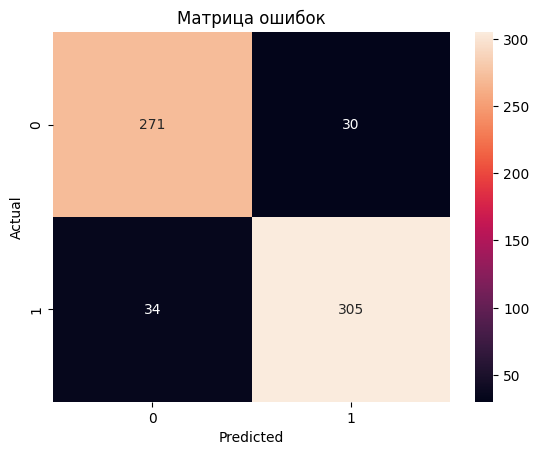

In [31]:
y_pred = model.predict(X_test_vec)
metrics(y_test, y_pred)

Не самые плохие результаты.

Но можно ли улучшить показатели модели? И за счет чего?

---
`CountVectorizer` будет создавать выбросы для слишком асто встречающихся слов, из-за чего будут занижаться значения для некоторых важных слов. Чтобы этого избежать, попробуем использовать другой векторизатор, TF-IDF.

> Термины "TF" (Term Frequency) и "IDF" (Inverse Document Frequency).
>
> TF (Частота термина) обозначает, насколько часто определенное слово появляется в данном документе. Таким образом, TF измеряет важность слова в контексте отдельного документа.
>
> IDF (Обратная частота документа) измеряет, насколько уникально слово является по всей коллекции документов. Слова, которые появляются в большинстве документов, имеют низкое IDF, так как они не вносят большой информационной ценности.

Формула TF-IDF комбинирует понятия TF и IDF, чтобы вычислить важность каждого слова в каждом документе. Формально, формула выглядит следующим образом:

> **TF-IDF(t, d) = TF(t, d) * IDF(t)**

Где:

TF(t, d) - Частота термина (TF) для слова "t" в документе "d".

IDF(t) - Обратная частота документа (IDF) для слова "t".

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

Как выглядит таблица и словарь? Напишите код, чтобы посмотреть.

In [33]:
# Корпус текстов можете заменить по желанию
txt = ['мама мыла раму',
      'мама чинила раму',
      'мама мыла, мама чинила']

In [34]:
# Создаем корпус текстов
txt = ['мама мыла раму',
      'мама чинила раму',
      'мама мыла, мама чинила']

# Инициализируем TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Применяем векторизацию к текстам
txt_tfidf = tfidf_vectorizer.fit_transform(txt)

# Преобразуем результат в массив
txt_tfidf_array = txt_tfidf.toarray()

# Получаем словарь
feature_names = tfidf_vectorizer.get_feature_names_out()

# Выводим таблицу и словарь
print("Таблица TF-IDF:")
print(txt_tfidf_array)

print("\nСловарь:")
print(feature_names)

Таблица TF-IDF:
[[0.48133417 0.61980538 0.61980538 0.        ]
 [0.48133417 0.         0.61980538 0.61980538]
 [0.73941068 0.47606294 0.         0.47606294]]

Словарь:
['мама' 'мыла' 'раму' 'чинила']


А теперь можно обучить модель с использованием данного векторизатора.

In [35]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       301
           1       0.91      0.91      0.91       339

    accuracy                           0.90       640
   macro avg       0.90      0.90      0.90       640
weighted avg       0.90      0.90      0.90       640



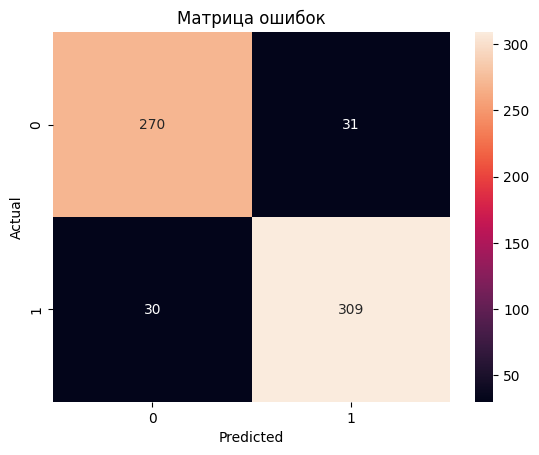

In [36]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
metrics(y_test, y_pred)

Изменения незначительны. На самом деле это связано с устройством самой модели. Даже в документации вы можете прочитать, что модель работает с дискретными целыми значениями. А TF-IDF, как мы видели, дробный. Однако, отметим, что всё равно модель успешно справилась.

---
Что ещё мы можем сделать?

Конечно, мы пропустили первый и важный этап обработки текста. Токенизация. Нам нужно превратить сплошной текст в набор токенов. Да, если разбитьь текст по пробелу, это тоже токены, однако, у нас в текстах могут встречаться числа и символы (иногда они нужны, но зачастую нет), а также одно и то же слово может быть представлено в различных словоформах (приставки, суффиксы, окончания). Со всем этим нужно работать.

Для борьбы со словоформами можно использовать два разных алгоритма:

> Лемматиза́ция — процесс приведения словоформы к лемме — её нормальной (словарной) форме.

> Сте́мминг (англ. stemming — находить происхождение) — это процесс нахождения основы слова для заданного исходного слова.

Мы используем лемматизацию, для этого подгрузим библиотеку `pymystem3`, разработанную в Яндекс.

In [37]:
from pymystem3 import Mystem
import re
import nltk
from nltk.corpus import stopwords

Мы создадим лемматизатор, а также загрузим список стоп-слов. Это такие слова, которые обычно не несут никакой смысловой нагрузки (союзы, предлоги, etc.).

In [38]:
m = Mystem()
nltk.download('stopwords')
stop_words = list(stopwords.words('russian'))

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Вот что получается при работе лемматизатора:

In [39]:
m.lemmatize('Интересного текста много не бывает')

['интересный', ' ', 'текст', ' ', 'много', ' ', 'не', ' ', 'бывать', '\n']

Также накинем регулярные выражения, чтоы оставить в каждом тексте только русские буквы. И лемматизируем полученные тексты.

In [40]:
train_ru = [" ".join(re.sub(r'[^а-яА-ЯёЁ]', ' ', text).split()) for text in X_train.values.astype('U')]
train_full = ' br '.join(train_ru)
train_lem = (''.join([word for word in m.lemmatize(train_full) if word != '\n'])).split(' br ')

test_ru = [" ".join(re.sub(r'[^а-яА-ЯёЁ]', ' ', text).split()) for text in X_test.values.astype('U')]
test_full = ' br '.join(test_ru)
test_lem = (''.join([word for word in m.lemmatize(test_full) if word != '\n'])).split(' br ')

In [41]:
train_lem

['шиитский вооруженный формирование обстреливать американский база в ирак',
 'погибший военкор журавлев отмечать литературный премия',
 'кто пересчитывать пенсия с ноябрь на индексация мочь рассчитывать несколько категория',
 'вылетать через окно страшный гибель жена известный блогер',
 'депутат ямпольская выражать соболезнование в связь со смерть гладков',
 'чтобы сближаться с мужчина просто задавать он этот вопрос',
 'за место в очередь для покупка билет на щелкунчик просить тысяча рубль',
 'музей восток на выставка россия представлять много сто экспонат',
 'в россия представлять отечественный мусоровоз гибрид',
 'путин поручать разрабатывать программа развитие электроэнергетика в дфо',
 'заявление захарова о мус прогреметь на весь мир',
 'ответ знать единица как часто нужно менять губка для мытье посуда',
 'в ран сделать заявление о таинственный инопланетный сигнал',
 'невероятный заявление диетолог мочь ли простой колбаса вызывать онкология',
 'умирать писательница нина садур',
 'м

А теперь к уже обработанному корпусу применим векторизатор и построим модель.

In [42]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
X_train_lem = tfidf_vectorizer.fit_transform(train_lem)
X_test_lem = tfidf_vectorizer.transform(test_lem)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       301
           1       0.90      0.89      0.89       339

    accuracy                           0.89       640
   macro avg       0.89      0.89      0.89       640
weighted avg       0.89      0.89      0.89       640



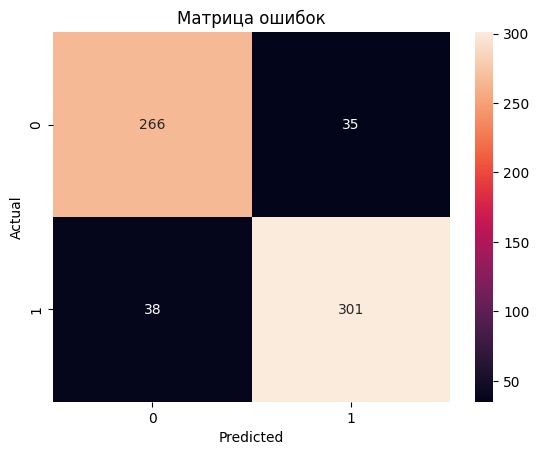

In [43]:
model = MultinomialNB()
model.fit(X_train_lem, y_train)
y_pred = model.predict(X_test_lem)
metrics(y_test, y_pred)

Результат стал даже чуть хуже, но вспомним об особенностях работы модели и попробуем это исправить. Попробуйте получить лучшие метрики.

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       301
           1       0.89      0.90      0.89       339

    accuracy                           0.89       640
   macro avg       0.89      0.89      0.89       640
weighted avg       0.89      0.89      0.89       640



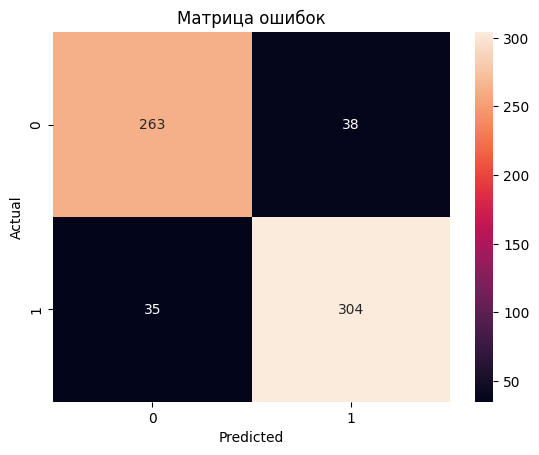

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
# Настройка параметров для GridSearch
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}

# Инициализация модели
model = MultinomialNB()

# Настройка GridSearch для поиска лучших параметров
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_lem, y_train)

# Получение лучших параметров
best_model = grid_search.best_estimator_

# Прогнозирование
y_pred = best_model.predict(X_test_lem)

# Вывод метрик
metrics(y_test, y_pred)

## Logistic Regression

---
Переходим к следующей модели.

Для обучения возьмем данные по диабету.

In [49]:
diabetes = pd.read_csv('diabetes_dataset.csv')

In [50]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.drop(['Outcome'], axis=1), diabetes['Outcome'], test_size=0.2, random_state=42)

Для логистической регрессии обязательно нужно нормализовать данные.

In [51]:
from sklearn.preprocessing import StandardScaler

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1275
           1       1.00      0.98      0.99       633

    accuracy                           0.99      1908
   macro avg       0.99      0.99      0.99      1908
weighted avg       0.99      0.99      0.99      1908



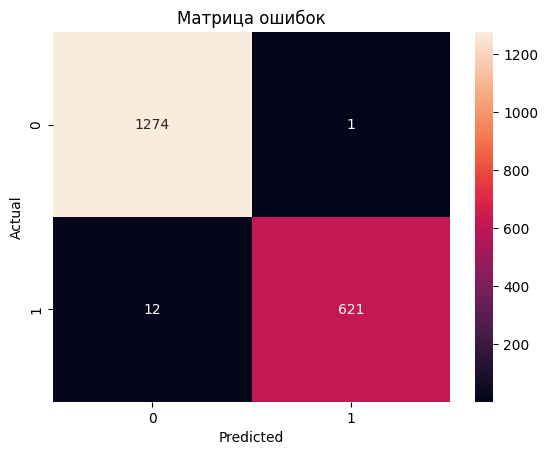

In [55]:
y_pred = clf.predict(X_test)
metrics(y_test, y_pred)

Однако, вы помните, что классы в этом датасете несббалансированны, а это не очень хорошо. Но логистическая модель может сама обучаться с поправкой на дисбаланс, главное указать это в аргументах.

In [56]:
clf = LogisticRegression(class_weight='balanced', random_state=42).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1275
           1       1.00      0.99      0.99       633

    accuracy                           1.00      1908
   macro avg       1.00      0.99      0.99      1908
weighted avg       1.00      1.00      1.00      1908



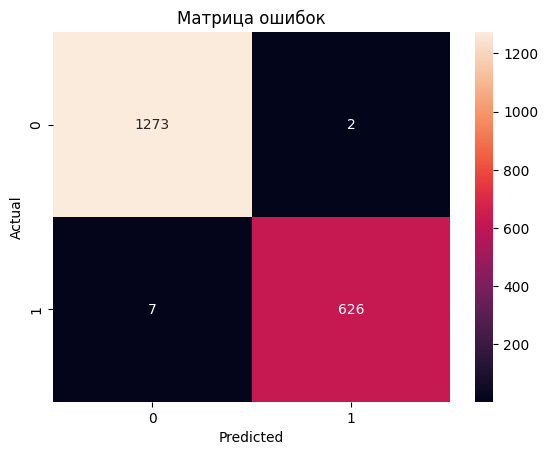

In [57]:
y_pred = clf.predict(X_test)
metrics(y_test, y_pred)

Рассмотрим ещё две метрики, позволяющие оценить качество модели. ROC-кривая и ROC-AUC.

---
Для построения этих показателей необходимо рассмотреть изменение порога классификации. Поскольку у нас всего два класса, можно рассматривать вероятность получения класса "1". По умолчанию порог равен 0.5 - получили значение выше 0.5, класс "1", ниже - "0".

Но этот порог можно изменять. Как будут вести себя точность и полнота, если снизить порог до 0.3? А если повысить до 0.8?

У логистической регрессии есть метод `predict_proba`, который автоматически считает вероятности для классов при различном пороге классификации.

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score

In [59]:
proba = clf.predict_proba(X_test)
proba_one = proba[:, 1]

In [60]:
proba

array([[8.78218188e-01, 1.21781812e-01],
       [3.10591431e-08, 9.99999969e-01],
       [9.94601126e-01, 5.39887441e-03],
       ...,
       [9.95488567e-01, 4.51143275e-03],
       [1.17832488e-06, 9.99998822e-01],
       [9.99281435e-01, 7.18565234e-04]])

In [61]:
proba_one

array([1.21781812e-01, 9.99999969e-01, 5.39887441e-03, ...,
       4.51143275e-03, 9.99998822e-01, 7.18565234e-04])

Нам нужны два важных значения. Вспомним матрицу ошибок

---
|           | Predicted: 0 | Predicted:1 |
|-----------|:------------:|:-----------:|
| Actual: 0 | TN           | FP          |
| Actual: 1 | FN           | TP          |

---
$TPR = \frac{TP}{TP+FN}$

$FPR = \frac{FP}{FP+TN}$

Что отражают TPR и FPR?

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, proba_one)

Text(0.5, 1.0, 'ROC-кривая')

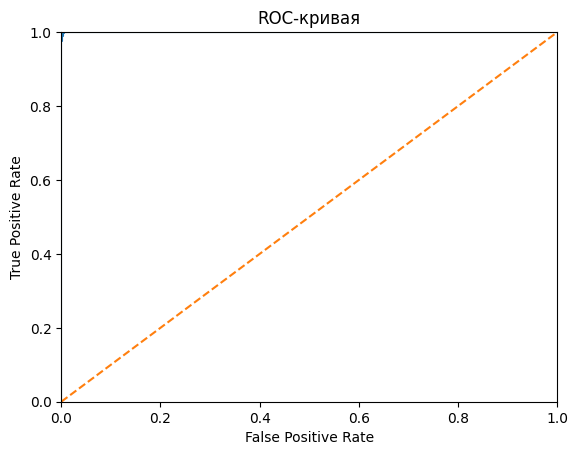

In [63]:
plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

Для данной модели ROC-кривая почти идеальна, это замечательно. А метрика AUC-ROC - это площадь под ROC-кривой.

In [64]:
auc_roc = roc_auc_score(y_test, y_pred)
print('AUC-ROC:',auc_roc)

AUC-ROC: 0.993686460366137


## Random Forest

---
Переходим к ансамблевому методу обучения.

Что такое ансамбль? Нет, не песни и пляски, а применительно к нашей теме.

> Ансамблевый метод - метод машинного обучения, где несколько моделей обучаются для решения одной и той же проблемы и объединяются для получения лучших результатов.

---
Есть два наиболее популярных класса ансаблевых методов: бэггинг и бустинг. О первом мы поговорим сейчас, а второй оставим на будущие темы.

> Бэггинг (от англ. bootstrap aggregating, бутстрэп-агрегирование) — ансамблевый метаалгоритм, предназначенный для улучшения стабильности и точности алгоритмов машинного обучения, используемых в задачах классификации и регрессии. Алгоритм также уменьшает дисперсию и помогает избежать переобучения.

Если задан стандартный тренировочный набор $D$ размера $n$, бэггинг образует $m$ новых тренировочных наборов $D_i$, каждый размером $n′$, путём выборки из $D$ равномерно и с возвратом. При семплинге с возвратом некоторые наблюдения могут быть повторены в каждой $D_i$. Этот вид семплинга известен как бутстрэп-семплинг. Эти $m$ моделей сглаживаются с помощью вышеупомянутых $m$ бутстрэп-выборок и комбинируются путём усреднения (для регрессии) или голосования (для классификации).

---
Именно так и устроен случайный лес. Но прежде чем обратиться к обучению моделей, пара слов о подготовке данных и выборе признаков. Используем всё те же данные по диабету.

In [65]:
diabetes

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,107.9,0.84,0,0,0,1,0
1,32,1,26.49,116.5,72.0,4.5,87.4,54.2,129.9,113.3,81.4,1.39,0,0,0,0,0
2,89,13,25.34,101.0,82.0,4.9,112.5,56.8,177.6,84.7,107.2,0.79,0,0,0,1,0
3,78,13,29.91,146.0,104.0,5.7,50.7,39.1,117.0,108.9,110.0,0.99,0,0,0,1,1
4,38,8,24.56,103.2,74.0,4.7,102.5,29.1,145.9,84.1,92.8,0.91,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9533,32,3,23.00,102.3,62.0,4.1,109.3,47.8,76.7,86.8,115.0,0.75,0,0,0,0,0
9534,74,0,24.29,125.8,93.0,5.3,95.8,66.6,103.7,90.1,94.3,0.96,1,0,0,1,1
9535,75,6,26.10,107.6,75.0,5.0,168.5,62.3,149.8,84.0,114.9,0.73,0,0,0,1,0
9536,52,1,25.88,99.3,96.0,4.6,70.0,48.4,122.9,97.5,88.7,1.10,1,0,0,0,1


Конечно, мы схитрим и изначально не будем использовать признак `FamilyHistory`, чтобы заведемо снизить качество модели.

Но у нас остаётся ещё 15 признаков. Да, это не так уж много, это не 200 признаков, когда их число точно хочется сократить. Но иногда и при небольшом количестве признаков стоит подумать и, возможно, от чего-то избавиться.

Один из простых шагов - убрать сильно коррелированные переменные.

Сильно коррелированные друг с другом переменные дают модели одну и ту же информацию, следовательно, для анализа не нужно использовать их все. Например, если набор данных (dataset) содержит признаки «Время в сети» и «Использованный трафик», можно предположить, что они будут в некоторой степени коррелированы, и мы увидим сильную корреляцию, даже если выберем непредвзятый образец данных. В таком случае в модели нужна только одна из этих переменных. Если использовать обе, то модель окажется переобучена (overfit) и предвзята относительно одного отдельного признака.

Посмотрите на корреляционную матрицу и поищите, какие признаки могут быть удалены.

<Axes: title={'center': 'Корреляционная матрица'}>

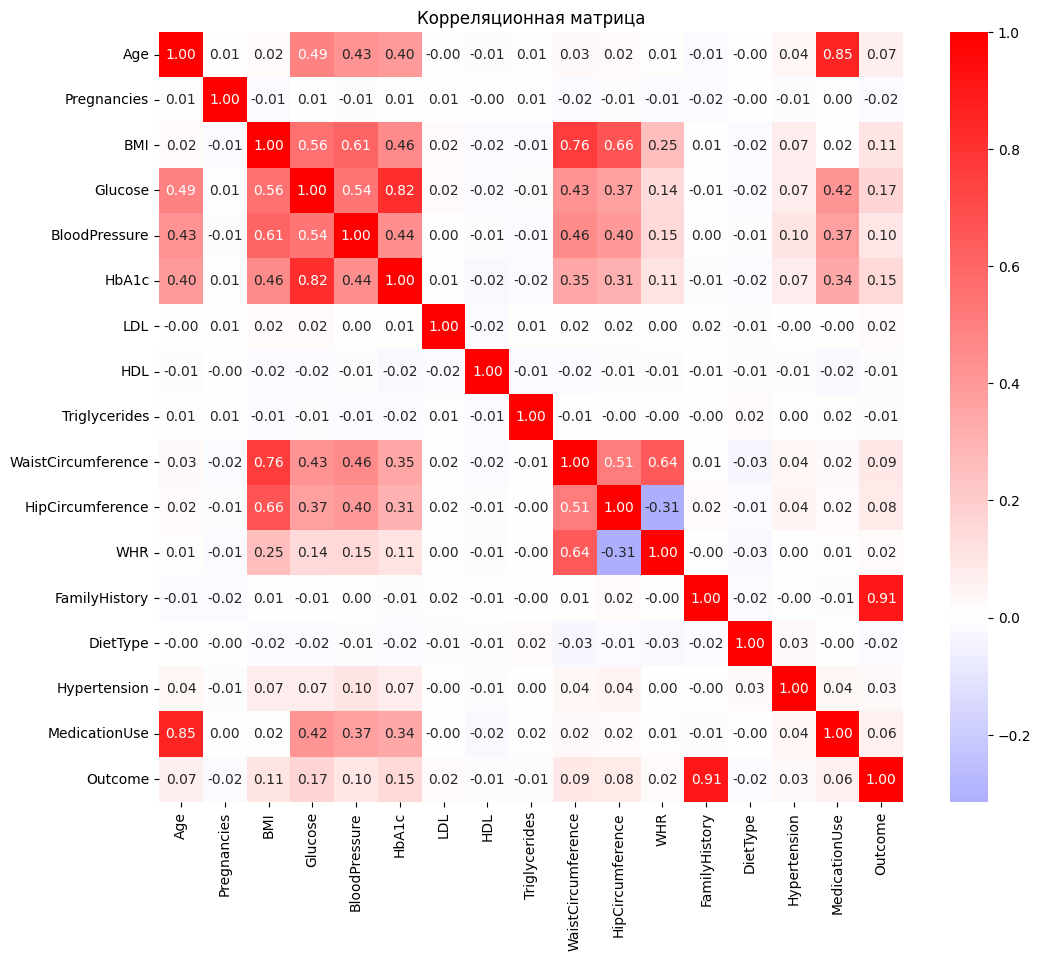

In [66]:
plt.figure(figsize=(12,10))
plt.title('Корреляционная матрица')
sns.heatmap(diabetes.corr(), cmap='bwr', center=0, annot=True, fmt='.2f')

Обучим простую модель случайного леса. Исключаю `FamilyHistory` для снижения метрик, глубину деревьев беру рандомно, число никак не подбиралось.

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.drop(['Outcome', 'FamilyHistory'], axis=1), diabetes['Outcome'], test_size=0.2, random_state=42)

In [69]:
rf = RandomForestClassifier(max_depth=8, random_state=42).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1275
           1       0.96      0.17      0.29       633

    accuracy                           0.72      1908
   macro avg       0.84      0.58      0.56      1908
weighted avg       0.79      0.72      0.65      1908



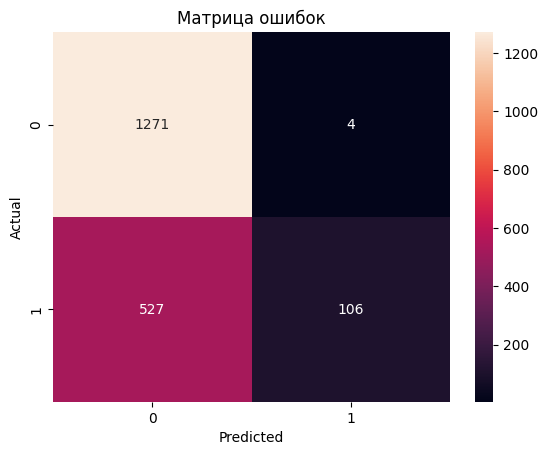

In [70]:
metrics(y_test, rf.predict(X_test))

А теперь повторим процесс, но из признаков исключим также `HbA1c`. Он сильно коррелирует с `Glucose`, а значит, они несут очень схожую информацию для модели. Посмотрим, к чему это приведет.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.drop(['Outcome', 'FamilyHistory', 'HbA1c'], axis=1), diabetes['Outcome'], test_size=0.2, random_state=42)

In [72]:
rf = RandomForestClassifier(max_depth=8, random_state=42).fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1275
           1       0.97      0.17      0.29       633

    accuracy                           0.72      1908
   macro avg       0.84      0.58      0.56      1908
weighted avg       0.80      0.72      0.65      1908



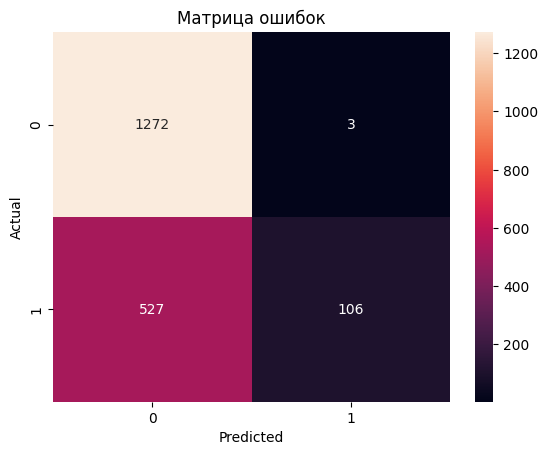

In [73]:
metrics(y_test, rf.predict(X_test))

Изменения почти отсутсвуют, но всё же есть, и в лучшую сторону. Значит такой подход к выбору признаков работает.

Есть множество способов отбора признаков, о некоторых поговорим, когда будем работать с регрессией.

А ещё можно посмотреть на важность признаков в обученной модели с помощью метода `feature_importances_`.

In [74]:
pd.Series(data=rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

,0
Glucose,0.510425
BMI,0.075237
WaistCircumference,0.057818
HipCircumference,0.055166
HDL,0.050402
Age,0.046472
LDL,0.044828
BloodPressure,0.044731
Triglycerides,0.043186
WHR,0.034389


Попробуйте построить ту же модель, исключив неважные признаки, изменится ли качество.

In [79]:
# Разделение данных на обучающую и тестовую выборки
X = diabetes.drop(['Outcome', 'FamilyHistory'], axis=1)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем модель случайного леса
rf = RandomForestClassifier(max_depth=8, random_state=42).fit(X_train, y_train)

# Получаем важность признаков
importances = rf.feature_importances_

# Создаем DataFrame с важностью признаков
feature_names = X.columns  # Используем X.columns, чтобы получить правильные названия признаков
feature_importances = pd.Series(data=importances, index=feature_names).sort_values(ascending=False)

# Выводим важность признаков
print("Важность признаков:")
print(feature_importances)

# Определяем порог для исключения неважных признаков
threshold = 0.05  # Вы можете изменить этот порог по своему усмотрению
important_features = feature_importances[feature_importances > threshold].index

# Обучаем модель, исключая неважные признаки
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

# Обучаем модель на отобранных признаках
rf_important = RandomForestClassifier(max_depth=8, random_state=42).fit(X_train_important, y_train)

# Оцениваем качество модели
y_pred = rf_important.predict(X_test_important)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Важность признаков:
Glucose               0.477840
HbA1c                 0.108520
BMI                   0.058385
HipCircumference      0.050953
WaistCircumference    0.045301
LDL                   0.041415
BloodPressure         0.039434
HDL                   0.039241
Triglycerides         0.037594
Age                   0.035978
WHR                   0.031951
Pregnancies           0.019013
DietType              0.007189
MedicationUse         0.007026
Hypertension          0.000160
dtype: float64
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1275
           1       0.98      0.17      0.28       633

    accuracy                           0.72      1908
   macro avg       0.84      0.58      0.56      1908
weighted avg       0.80      0.72      0.65      1908

[[1273    2]
 [ 528  105]]


Также посмотрим на ROC-кривую для такой модели (у случайного леса тоже есть такие методы).

In [80]:
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

Text(0.5, 1.0, 'ROC-кривая')

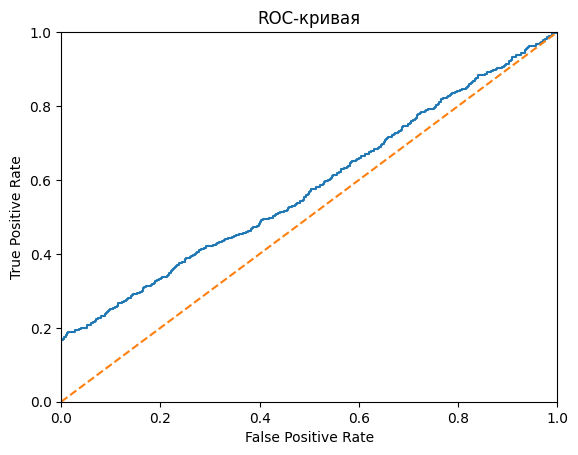

In [81]:
plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

In [82]:
auc_roc = roc_auc_score(y_test, rf.predict(X_test))
print(auc_roc)

0.5821596505900938


## GridSearchCV

---
В прошлый раз мы говорили о кросс-валидации, которая помогает получить более правильные метрики при усреднении нескольких моделей.

Но куда важнее для модели подобрать нужные гиперпараметры, от этого зависит очень многое, метрики могут отличаться значительно. Самое простое, что можно сделать - ручной перебор, меняем гиперпараметр, обучаем, проверяем, и так по кругу, пока не получим оптимальный результат. Но, это скучно и утомительно, поэтому можно воспользоваться `GridSearchCV`, который проделает тот же процесс самостоятельно. Более того, он попутно проводит и кросс-валидацию.

In [83]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.drop(['Outcome', 'FamilyHistory'], axis=1), diabetes['Outcome'], test_size=0.2, random_state=42)

In [84]:
rf = RandomForestClassifier()

In [85]:
from sklearn.model_selection import GridSearchCV

В `SridSearchCV` мы передаем нужную нам модель и перечень гиперпараметров, которые хотим варьировать, с желаемыми значениями. Также можно указать, на сколько частей бить данные при кросс-валидации, и желаемую метрику. Сколько раз будет обучаться модель при следующих параметрах?

In [86]:
parameters = {'max_depth': [5, 8], 'n_estimators': [50, 100], 'random_state': [42]}
clf = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 8], 'n_estimators': [50, 100],
                         'random_state': [42]},
             scoring='roc_auc')

А после обучения можно посмотреть на лучшую оценку, лучшую модель и просто посмотреть на все результаты обучения.

In [87]:
clf.best_score_

np.float64(0.5953933447533425)

In [88]:
clf.best_params_

{'max_depth': 8, 'n_estimators': 100, 'random_state': 42}

In [89]:
clf.cv_results_

{'mean_fit_time': array([0.32828803, 0.63752108, 0.45139747, 1.12800164]),
 'std_fit_time': array([0.01579613, 0.01714949, 0.00754081, 0.1424468 ]),
 'mean_score_time': array([0.01115851, 0.01893978, 0.01331878, 0.02614493]),
 'std_score_time': array([0.00082581, 0.00262234, 0.00097804, 0.00247106]),
 'param_max_depth': masked_array(data=[5, 5, 8, 8],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_random_state': masked_array(data=[42, 42, 42, 42],
              mask=[False, False, False, False],
        fill_value=999999),
 'params': [{'max_depth': 5, 'n_estimators': 50, 'random_state': 42},
  {'max_depth': 5, 'n_estimators': 100, 'random_state': 42},
  {'max_depth': 8, 'n_estimators': 50, 'random_state': 42},
  {'max_depth': 8, 'n_estimators': 100, 'random_state': 42}],
 'split0_test_score': array([0.59865039, 0

Попробуйте использовать `GridSearchCV` с тем набором признаков, который считаете оптимальным. Подберите лучший набор гиперпараметров, выберите метрику и посмотрите, какого результата сможете достичь.

Метрики можно посмотреть тут: [scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [90]:
%time
# этот код позволяет вывести итоговое время выполнения ячейки, если вам интересно засечь время обучения

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


CPU times: user 45.5 s, sys: 114 ms, total: 45.6 s
Wall time: 46.3 s
Лучший ROC AUC: 0.5967185633090616
Лучшие параметры: {'max_depth': 10, 'n_estimators': 100}
Результаты кросс-валидации: {'mean_fit_time': array([0.51204963, 0.72459221, 1.16310668, 0.45286317, 0.90068016,
       1.57777371, 0.5477181 , 1.1107399 , 1.80413442]), 'std_fit_time': array([0.0537436 , 0.16446331, 0.18452851, 0.01115364, 0.01950375,
       0.23526431, 0.01295093, 0.04605459, 0.2441925 ]), 'mean_score_time': array([0.01945243, 0.01984296, 0.02914839, 0.01343718, 0.02363248,
       0.03325815, 0.01475945, 0.02644019, 0.0352396 ]), 'std_score_time': array([0.00263598, 0.00321278, 0.0043874 , 0.0019359 , 0.0023939 ,
       0.00372102, 0.00103073, 0.00251876, 0.00374438]), 'param_max_depth': masked_array(data=[5, 5, 5, 8, 8, 8, 10, 10, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value=999999), 'param_n_estimators': masked_array(data=[50, 1

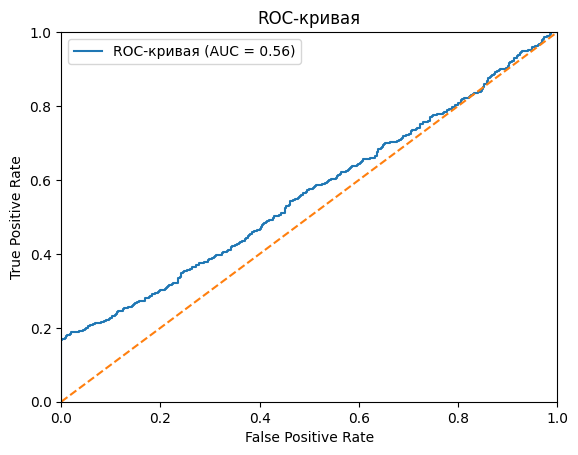

In [91]:
# Разделение данных на обучающую и тестовую выборки
X = diabetes.drop(['Outcome', 'FamilyHistory'], axis=1)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определяем модель случайного леса
rf = RandomForestClassifier(random_state=42)

# Определяем параметры для GridSearchCV
parameters = {
    'max_depth': [5, 8, 10],
    'n_estimators': [50, 100, 150]
}

# Инициализация GridSearchCV
clf = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc')

# Обучение модели
%time clf.fit(X_train, y_train)

# Выводим результаты
print("Лучший ROC AUC:", clf.best_score_)
print("Лучшие параметры:", clf.best_params_)
print("Результаты кросс-валидации:", clf.cv_results_)

# Оценка на тестовой выборке
y_pred_proba = clf.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC на тестовой выборке:", auc_roc)

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='ROC-кривая (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

## Multiclass classification

---
Всюду до этого мы рассматривали случаи бинарной классификации, где у нас были только два класса. Однако зачастую нам нужно классифицировать данные по нескольким группам. Есть два подхода к использванию бинарных классификаторов для многоклассовой классификации.

> Один против всех (One-versus-all, OvA или один против остальных, One-versus-rest, OvR). Для каждого класса строится один бинарный классификатор. При этом примеры класса определяются как «положительные», а всех других — как «отрицательные». Итоговый результат формируется по принципу «победитель получает все»: объект будет отнесен к классу, для которого бинарный классификатор даст большее число «положительных» примеров.

> Один против одного (One versus One, OvO). Строится $k(k−1)$ классификаторов, позволяющих различить любую пару примеров разных классов. Алгоритм просматривает все пары примеров с разными метками классов и для каждой решает бинарную задачу $f_{ij}$. В каждом случае для пар $(i,j)$ положительные — все примеры с метками $i$, а отрицательными — с $j$.

Какие недостатки можно отметить у обоих способов?

Но многие модели просто умеют работать с несколькими классами. Например, случайный лес делает это легко.

Для демонстрации загрузим новые данные.

Этот набор данных содержит исчерпывающую информацию о 2392 учениках старших классов, в которой подробно описываются их демографические данные, привычки в учебе, участие родителей, внеклассные мероприятия и успеваемость. Целевая переменная, `GradeClass`, классифицирует оценки учеников по отдельным категориям, предоставляя надежный набор данных для образовательных исследований, прогнозного моделирования и статистического анализа.

In [93]:
stud = pd.read_csv('Student_performance_data.csv')

In [ ]:
stud

Теперь обучим модель и посмотрим на метрики.

In [94]:
X_train, X_test, y_train, y_test = train_test_split(stud.drop(['GradeClass'], axis=1), stud['GradeClass'], test_size=0.2, random_state=42)

In [95]:
rf = RandomForestClassifier(max_depth=8).fit(X_train, y_train)

              precision    recall  f1-score   support

         0.0       1.00      0.23      0.37        22
         1.0       0.70      0.88      0.78        49
         2.0       0.90      0.87      0.89        85
         3.0       0.89      0.91      0.90        86
         4.0       0.95      0.98      0.97       237

    accuracy                           0.90       479
   macro avg       0.89      0.77      0.78       479
weighted avg       0.91      0.90      0.89       479



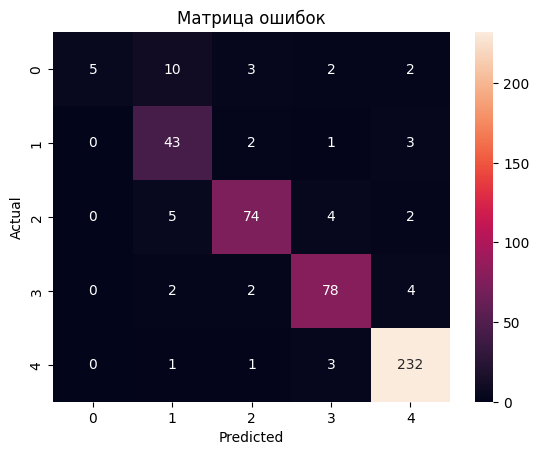

In [96]:
metrics(y_test, rf.predict(X_test))

Как видим, теперь для каждого класса у нас есть набор метрик, а также общие оценки.

И тепловая карта с матрицей ошибок выглядит лучше. Однако на ней заметен дисбаланс классов. А когда мы хотим оценить, где модель делает наибольшие ошибки, нам лучше занулить диагональ. Для этого в нашей функции `metrics` предусмотрен код.

              precision    recall  f1-score   support

         0.0       1.00      0.23      0.37        22
         1.0       0.70      0.88      0.78        49
         2.0       0.90      0.87      0.89        85
         3.0       0.89      0.91      0.90        86
         4.0       0.95      0.98      0.97       237

    accuracy                           0.90       479
   macro avg       0.89      0.77      0.78       479
weighted avg       0.91      0.90      0.89       479



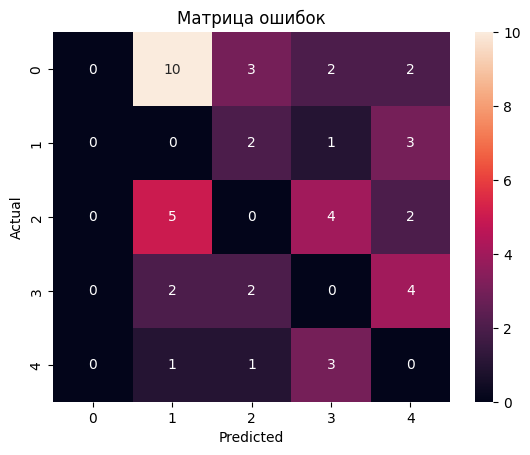

In [97]:
metrics(y_test, rf.predict(X_test), True)

Тут видно, где модель ошибается боьше всего.

В завершение предлагаю вам настроить и эту модель, подобрав лучшие гиперпараметры.

CPU times: user 56.7 s, sys: 182 ms, total: 56.9 s
Wall time: 57.4 s
Лучший accuracy: 0.9247248916654136
Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy на тестовой выборке: 0.9144050104384134
              precision    recall  f1-score   support

         0.0       0.91      0.45      0.61        22
         1.0       0.80      0.90      0.85        49
         2.0       0.91      0.88      0.90        85
         3.0       0.85      0.88      0.87        86
         4.0       0.96      0.98      0.97       237

    accuracy                           0.91       479
   macro avg       0.89      0.82      0.84       479
weighted avg       0.92      0.91      0.91       479



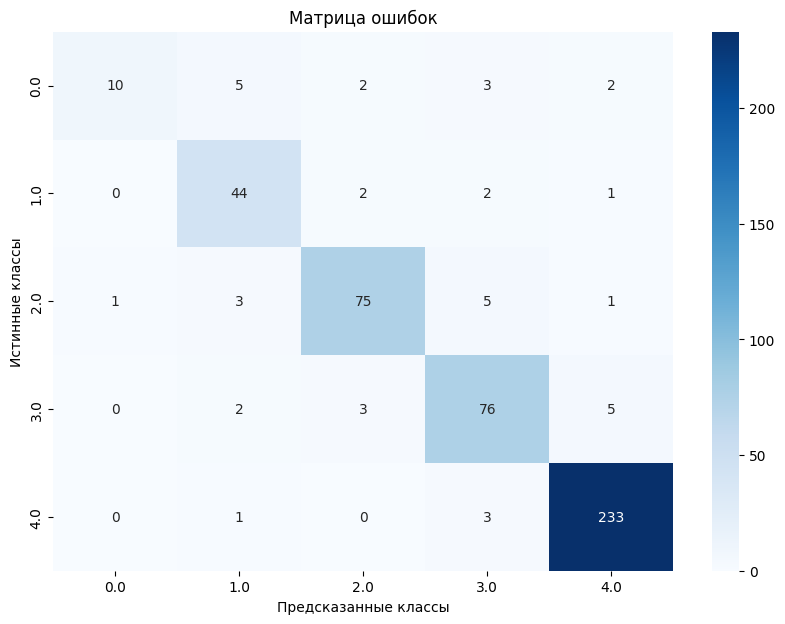

In [100]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Разделение данных на обучающую и тестовую выборки
X = stud.drop(['GradeClass'], axis=1)
y = stud['GradeClass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определяем модель случайного леса
rf = RandomForestClassifier(random_state=42)

# Определяем параметры для GridSearchCV
parameters = {
    'max_depth': [5, 8, 10],
    'n_estimators': [50, 100, 150],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Инициализация GridSearchCV
clf = GridSearchCV(rf, parameters, cv=5, scoring='accuracy')

# Обучение модели
%time clf.fit(X_train, y_train)

# Выводим результаты
print("Лучший accuracy:", clf.best_score_)
print("Лучшие параметры:", clf.best_params_)

# Оценка на тестовой выборке
y_pred = clf.predict(X_test)
print("Accuracy на тестовой выборке:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок')
plt.show()